In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import OpenEXR
import Imath
import array
import os 

# %pylab inline
class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
        
def read_exr(filename):
    file = OpenEXR.InputFile(filename)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B")]

    # Normalize the data to the range [0, 1]
    img = np.zeros((size[1], size[0], 3), dtype=np.float32)
    # img[:,:,0] = np.array(R).reshape(size[1], size[0]) / max(R)
    # img[:,:,1] = np.array(G).reshape(size[1], size[0]) / max(G)
    # img[:,:,2] = np.array(B).reshape(size[1], size[0]) / max(B)
    img[:,:,0] = np.array(R).reshape(size[1], size[0]) #/ max(R)
    img[:,:,1] = np.array(G).reshape(size[1], size[0]) #/ max(G)
    img[:,:,2] = np.array(B).reshape(size[1], size[0]) #/ max(B)

    return img
    
def center_crop(img_array, new_width, new_height):
    height, width, _ = img_array.shape
    # print(height,width)
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    return img_array[top:bottom, left:right]


def simple_tone_mapping(img, gamma=2.2, exposure=1.0):
    return np.power(img * exposure, 1/gamma)



def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='#d8d8d8', lw=2,clip_on=False)

    ax.text((xmax+xmin)/2., yy+.09*yspan, text, ha='center', va='bottom',fontsize=20)
    


In [41]:
rootdir = "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp"

csvs = [
   os.path.join(rootdir,"fig7/csv/fig7_head_ours_32spp_playfuljazz80.csv"), # Ours
    os.path.join(rootdir,"fig7/csv/fig7_head_psdr_32spp_glamoroussnowflake26.csv"), # 32spp, psdr
    os.path.join(rootdir,"fig7/csv/fig7_head_psdr_128spp_livelybrook27.csv"), # 32spp, psdr
    
    
    # Theirs
    os.path.join(rootdir,"fig7/csv/fig7_kettle_ours_32spp_fluentdarkness75.csv"), # Ours
    os.path.join(rootdir,"fig7/csv/fig7_kettle_psdr_32spp_darkmoon.csv"), # Ours
    os.path.join(rootdir,"fig7/csv/fig7_kettle_psdr_128spp_legendarysponge24.csv") # Ours
    ]

legends  = [
    'Ours',
    'Volpath. (32 spp)',
    'Volpath. (128 spp)',
]

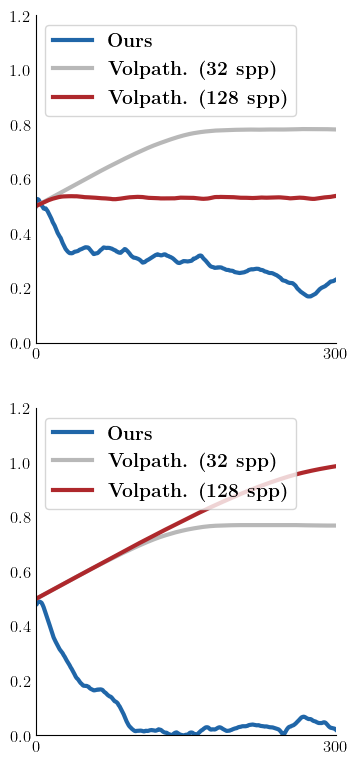

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import OpenEXR
import Imath
import array


# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})

n_cols = 1
n_rows = 2
size = 3

# Create figure and grid
fig = plt.figure(figsize=(size*n_cols,size*n_rows))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,]*n_cols,
                      # width_ratios=[1, 1, 1, 1, 1, 1],
                      height_ratios=[1,]*n_rows,
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols):        
        ax = fig.add_subplot(gs[row, col])

        for i in range(3):
            # Step 1: Read the CSV file
            df  = pd.read_csv(csvs[row*3 + i])
            
            # Step 2: Separate the time step column from the error columns
            time_steps = df.iloc[:, 0]  # First column as time steps
            data = df.iloc[:, 1:]  # Remaining columns as error data

            if i != 0:
                data = data*0.01
            # Step 4: Plot each error column
            for idx,column in enumerate(data.columns):
                ax.plot(time_steps, data[column], color=colors[i],label=r'\textbf{'+legends[i]+'}',linewidth=3)
                break
            
        # Remove the box border (spines)
        for spine in ['top', 'right',]: # 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
                
        plt.xticks(np.arange(0, 301, 300))  # X-axis ticks from 0 to 10 with a step of 
        ax.set_xlim(0,300)
        # if row % 2 == 0:
        #     plt.yticks([0.1,])  # Y-axis ticks from -1 to 1 with a step of 0.5
        #     # ax.set_ylim(0,0.13)
        # else:
            # plt.yticks([0.5,])
            # ax.set_ylim(0,0.8)
        plt.legend(fontsize=14,loc='upper left')
        ax.set_ylim(0,1.2)
                    
        # Remove tick marks but keep numeric labels
        ax.tick_params(axis='both', which='both', length=0, labelsize=12)
        # title_text = r'$\textbf{' + ('Albedo' if row % 2 == 0 else 'SigmaT' ) + '}$'
        # props = dict(boxstyle='round', facecolor='white', alpha=0.2)
        # ax.text(0.95,0.99, title_text, transform=ax.transAxes, fontsize=14,
        #         verticalalignment='top', horizontalalignment='right', bbox=props)
plt.tight_layout()

plt.subplots_adjust(hspace=0.2, wspace=0.0,left=0.0,top=1.2,right=1.0,bottom=0.0)

# plt.savefig(f'figures/fig6_plot.pdf',bbox_inches='tight') 
plt.savefig(f'figures/fig7_plot.png',bbox_inches='tight') 
plt.show()

In [108]:

pths = [
     os.path.join(rootdir,"fig7/results/head_init.exr"),
     os.path.join(rootdir,"fig7/results/head_target.exr"),
     os.path.join(rootdir,"fig7/results/head_psdr_32_res.exr"),
     os.path.join(rootdir,"fig7/results/head_psdr_128_res.exr"),
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/head4/fig7_ours_32spp_res/iter_1_1_out.exr",
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_init_target/iter_1_1_gt.exr",
    
     os.path.join(rootdir,"fig7/results/kettle_init.exr"),
     os.path.join(rootdir,"fig7/results/kettle_target.exr"),
     os.path.join(rootdir,"fig7/results/kettle_psdr_32_res.exr"),
     os.path.join(rootdir,"fig7/results/kettle_psdr_128_res.exr"),
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle4/fig7_ours_32spp_res/iter_1_1_out.exr",
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/maneki4/fig4/iter_1_3_out.exr",
]

text_cols = [r'\textbf{(a) Initial}',
             r'\textbf{(b) Target}',
            r'\textbf{(c) Opt.}'+'\n'+r'\textbf{Volpath.(32 spp)}',
            r'\textbf{(d) Opt.}'+'\n'+r'\textbf{Volpath.(128 spp)}',
            r'\textbf{(e) Opt.}'+'\n'+r'\textbf{Ours (32 spp)}',
             r'\textbf{(f) Param. RMSE}' + '\n' + r'Ext. Coeff. $\sigma_t$'
            ]
text_cols = [r'(a) Initial',
             r'(b) Target',
            r'(c) Opt.'+'\n'+r'\textbf{Volpath.(32 spp)}',
            r'(d) Opt.'+'\n'+r'\textbf{Volpath.(128 spp)}',
            r'(e) Opt.'+'\n'+r'\textbf{Ours (32 spp)}',
             r'(f) Param. RMSE' + '\n' + r'\textbf{Ext. Coeff. $\sigma_t$}'
            ]


colors=[
    '#2066a8', # Ours
    '#b8b8b8', # Naive
    '#ae282c' # Planar
]

space_cols = [
    # 1/6,
    1/12,
    1/12,
    1/12-0.01,
    1/12-0.01, 
    1/12-0.02, 
    1/12-0.02,
    0.01,
    -0.01,
    1/12,
]
text_rows = ['Head',
            'Kettle',
            ]
space_rows = [
    0.77,
    0.8,
]
scale = 0.9
list_imgs = []
for pth in pths:
    if pth.endswith('exr'):
        # Load exr
        img = read_exr(pth)
        img = center_crop(img,new_width=480,new_height=480)
                
        # Apply tone mapping
        img = simple_tone_mapping(img, gamma=2.2, exposure=1.5)
    elif pth.endswith('npy'):
        # Apply colormap
        img = np.load(pth)
    list_imgs.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(765, 357, 3)


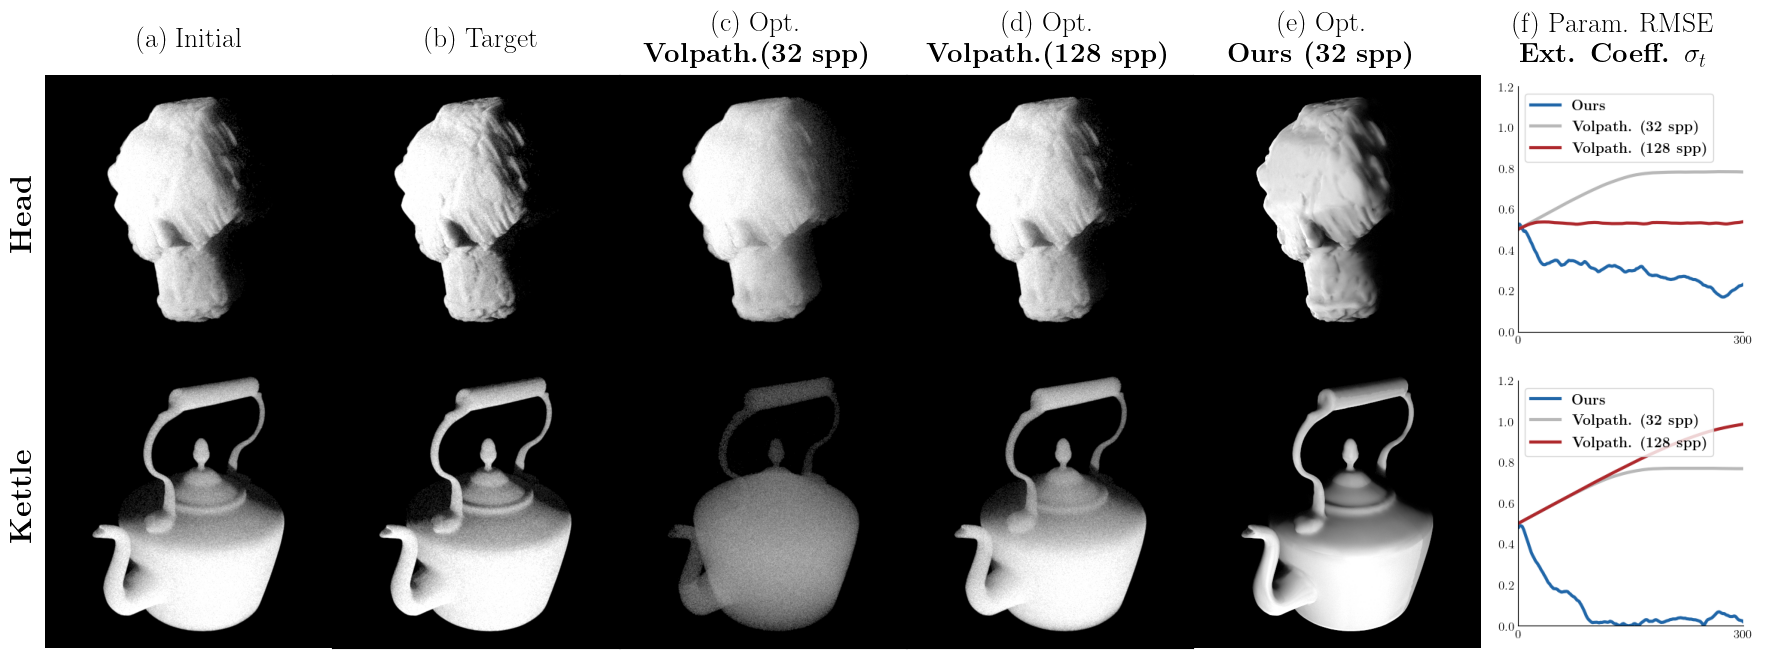

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import OpenEXR
import Imath
import array
import cv2



# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})

n_cols = 6
n_rows = 2
size = 3

# Create figure and grid
fig = plt.figure(figsize=(size*n_cols-0.5,size*n_rows))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,]*n_cols,
                      # width_ratios=[1, 1, 1, 1, 1, 1],
                      height_ratios=[1, 1],
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols-1):
   
        ax = fig.add_subplot(gs[row, col])
        img = list_imgs[row*n_cols + col]
        
        im = ax.imshow(img)

        if col in [0,4,5]:
            ax.axis('off')
        else:
            # for spine in ['top', 'right', 'bottom', 'left']:
            #     ax.spines[spine].set_visible(True)
            #     ax.spines[spine].set_color(colors[3 - col])
            #     ax.spines[spine].set_linewidth(4)
                
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            
# Create the subplot that spans both rows in the last column
ax_plot = fig.add_subplot(gs[:, n_cols-1])
img = cv2.imread('figures/fig7_plot.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
im = ax_plot.imshow(img)    
ax_plot.axis('off') 


# Add column captions with LaTeX formatting
for col in range(n_cols):
    # fig.text(col/n_cols + space_cols[col], 1.03, r'$\textbf{' + text_cols[col] + '}$', # +r'$\textbf{' + text_cols[col] + '}$', 
             
    # fig.text(col/n_cols + space_cols[col] ,-0.01, r'$\textbf{' + text_cols[col] + '}$', ha='center', va='center',fontsize=20)
    fig.text(col/n_cols + space_cols[col] ,1.06, text_cols[col], ha='center', va='center',fontsize=20)

# Add row captions with LaTeX formatting
for row in range(n_rows):
    fig.text(-0.02, space_rows[row] - row*0.5, r'$\textbf{' + text_rows[row] + '}$', ha='left', va='center', rotation=90,fontsize=22)


# Adjust layout
plt.tight_layout()
# plt.subplots_adjust(top=0.85, left=0.05, right=0.95, bottom=0.05, wspace=0.1, hspace=0.2)

plt.subplots_adjust(left=0.0,top=1.0,hspace=0.0, wspace=0.00)

plt.savefig(f'figures/fig7_rev.pdf',bbox_inches='tight') 
plt.savefig(f'figures/fig7_rev.png',bbox_inches='tight') 
plt.show()

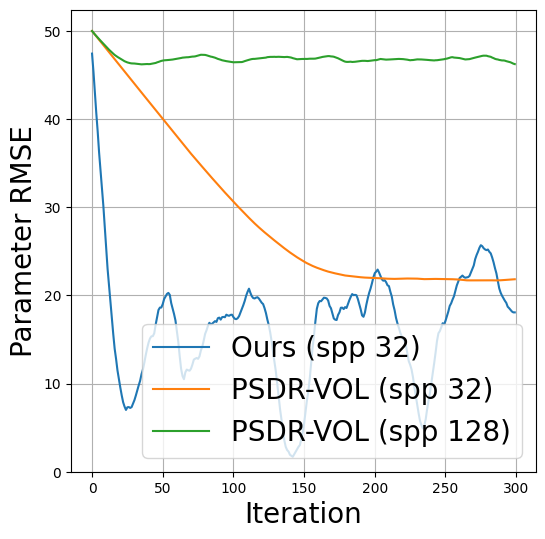

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def compute_rmse(init, target, log_file1, log_file2, csv_file, save_path=None):
    # Read data from log files
    iter_offsets_1 = np.loadtxt(log_file1, delimiter=',')
    iter_offsets_2 = np.loadtxt(log_file2, delimiter=',')

    # Read data from CSV file
    df = pd.read_csv(csv_file) #'/home/spock-the-wizard/Downloads/figures/head1_rmse_sigT_exp174.csv')
    # tag = csv_pth.split('/')[-1].split('.')[0].split('_')
    # scene = tag[0]
    # name = name2cat(csv_pth) #tag[2])
    # expname = tag[-1]
    # Step 2: Process the data if needed
    df['Step'] = pd.to_datetime(df['Step'])
    exponential_values = df.iloc[:,1] #plt.plot(np.arange(300), df.iloc[:,1], marker='',label='Auto. Diff.')
    # plt.figure(figsize=(7, 6))
    # exponential_values = np.genfromtxt(csv_file, delimiter=',', usecols=1)
    # print(iter_offsets_1)
    # Calculate parameter values
    param_values_1 = init - iter_offsets_1[:, 1]
    param_values_2= init - iter_offsets_2[:, 1]
    param_values_3 = np.exp(exponential_values)
    # print(param_values_3)

    # Compute RMSE
    # rmse_1 = np.sqrt(np.mean((param_values_1 - target)**2))
    # rmse_2 = np.sqrt(np.mean((param_values_2 - target)**2))
    # rmse_3 = np.sqrt(np.mean((param_values_3 - target)**2))
    rmse_1 = np.sqrt((param_values_1 - target)**2)
    rmse_2 = np.sqrt((param_values_2 - target)**2)
    rmse_3 = np.sqrt((param_values_3 - target)**2)

    # Plot RMSE
    plt.figure(figsize=(6, 6))
    # plt.plot(iter_offsets_1[:, 0], param_values_1, label='Log File 1')
    # plt.plot(iter_offsets_2[:, 0], param_values_2, label='Log File 2')
    # plt.plot(iter_offsets_1[:, 0], param_values_3, label='Log File 2')
    plt.plot(iter_offsets_1[:, 0], rmse_3, label='Ours (spp 32)')
    plt.plot(iter_offsets_1[:, 0], rmse_1, label='PSDR-VOL (spp 32)')
    plt.plot(iter_offsets_2[:, 0], rmse_2, label='PSDR-VOL (spp 128)')
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel('Parameter RMSE',fontsize=20)
    plt.ylim(0)
    # plt.title('Parameter Estimation')
    plt.legend(fontsize=20)
    plt.grid(True)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

    # print("RMSE for Log File 1:", rmse_1)
    # print("RMSE for Log File 2:", rmse_2)
    plt.close()

compute_rmse(init=50, target=100, 
             log_file1='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_32.log', 
             log_file2='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_128.log', 
             # csv_file='/home/spock-the-wizard/Downloads/figures/head4_param_sigT_exp20.csv',
             csv_file='/home/spock-the-wizard/Downloads/figures/ours_head4_param_sigT_exp209.csv',
             # save_path='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/tmp.png',
)
# # Example usage
# compute_rmse(init=50, target=100, 
#              log_file1='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_32.log', 
#              log_file2='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_128.log', 
#              csv_file='/home/spock-the-wizard/Downloads/figures/ours_head4_param_sigT_exp209.csv',
#              save_path='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/tmp.png',
#             #  save_path='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/tmp.png',
# ) 
# compute_rmse(init=50, target=100, 
#              log_file1='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/kettle4/param_32.log', 
#              log_file2='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/kettle4/param_128.log', 
#              csv_file='/home/spock-the-wizard/Downloads/figures/ours_kettle4_param_sigT_exp209.csv',
#              save_path='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/plot_kettle4.png',
# ) 


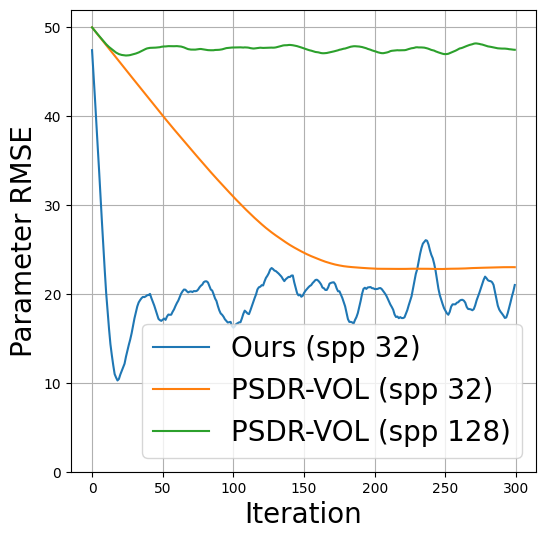

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def compute_rmse(init, target, log_file1, log_file2, csv_file, save_path=None):
    # Read data from log files
    iter_offsets_1 = np.loadtxt(log_file1, delimiter=',')
    iter_offsets_2 = np.loadtxt(log_file2, delimiter=',')

    # Read data from CSV file
    df = pd.read_csv(csv_file) #'/home/spock-the-wizard/Downloads/figures/head1_rmse_sigT_exp174.csv')
    # tag = csv_pth.split('/')[-1].split('.')[0].split('_')
    # scene = tag[0]
    # name = name2cat(csv_pth) #tag[2])
    # expname = tag[-1]
    # Step 2: Process the data if needed
    df['Step'] = pd.to_datetime(df['Step'])
    exponential_values = df.iloc[:,1] #plt.plot(np.arange(300), df.iloc[:,1], marker='',label='Auto. Diff.')
    # plt.figure(figsize=(7, 6))
    # exponential_values = np.genfromtxt(csv_file, delimiter=',', usecols=1)
    # print(iter_offsets_1)
    # Calculate parameter values
    param_values_1 = init - iter_offsets_1[:, 1]
    param_values_2= init - iter_offsets_2[:, 1]
    param_values_3 = np.exp(exponential_values)
    # print(param_values_3)

    # Compute RMSE
    # rmse_1 = np.sqrt(np.mean((param_values_1 - target)**2))
    # rmse_2 = np.sqrt(np.mean((param_values_2 - target)**2))
    # rmse_3 = np.sqrt(np.mean((param_values_3 - target)**2))
    rmse_1 = np.sqrt((param_values_1 - target)**2)
    rmse_2 = np.sqrt((param_values_2 - target)**2)
    rmse_3 = np.sqrt((param_values_3 - target)**2)

    # Plot RMSE
    plt.figure(figsize=(6, 6))
    # plt.plot(iter_offsets_1[:, 0], param_values_1, label='Log File 1')
    # plt.plot(iter_offsets_2[:, 0], param_values_2, label='Log File 2')
    # plt.plot(iter_offsets_1[:, 0], param_values_3, label='Log File 2')
    plt.plot(iter_offsets_1[:, 0], rmse_3, label='Ours (spp 32)')
    plt.plot(iter_offsets_1[:, 0], rmse_1, label='PSDR-VOL (spp 32)')
    plt.plot(iter_offsets_2[:, 0], rmse_2, label='PSDR-VOL (spp 128)')
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel('Parameter RMSE',fontsize=20)
    plt.ylim(0)
    # plt.title('Parameter Estimation')
    plt.legend(fontsize=20)
    plt.grid(True)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

    # print("RMSE for Log File 1:", rmse_1)
    # print("RMSE for Log File 2:", rmse_2)
    plt.close()

compute_rmse(init=50, target=100, 
             log_file1='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/kettle4/param_32.log', 
             log_file2='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/kettle4/param_128.log', 
             # csv_file='/home/spock-the-wizard/Downloads/figures/head4_param_sigT_exp20.csv',
             csv_file='/home/spock-the-wizard/Downloads/figures/ours_kettle4_param_sigT_exp209.csv',
             # save_path='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/tmp.png',
)

[50.       50.199207 50.387593 50.568419 50.74241  50.921187 51.09638
 51.26965  51.43965  51.61359  51.78323  51.95697  52.11824  52.27207
 52.42267  52.57135  52.71405  52.83358  52.94049  53.0345   53.12866
 53.23177  53.33647  53.42849  53.5013   53.5629   53.6113   53.6488
 53.67596  53.68105  53.68846  53.70745  53.7285   53.74635  53.76388
 53.78281  53.77179  53.75314  53.74069  53.74486  53.75661  53.75059
 53.71862  53.68917  53.66088  53.62503  53.55752  53.50802  53.44369
 53.38954  53.35629  53.32631  53.31792  53.30177  53.28205  53.2714
 53.25794  53.23641  53.20861  53.17274  53.15583  53.12072  53.09425
 53.0608   53.02363  53.00584  52.9853   52.97857  52.9751   52.94609
 52.92613  52.90242  52.89632  52.87562  52.83058  52.78812  52.73742
 52.69481  52.69423  52.70546  52.71336  52.7532   52.80603  52.86186
 52.9052   52.9345   52.98091  53.02853  53.09678  53.16277  53.20774
 53.26015  53.31902  53.35516  53.3997   53.42104  53.4478   53.4715
 53.5133   53.53146  53

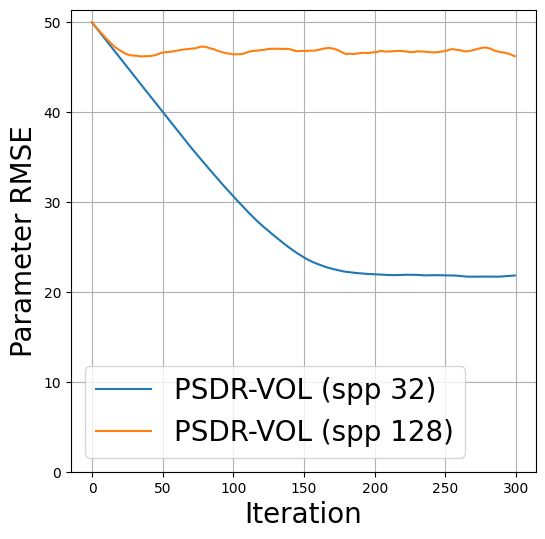

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rmse(init, target, log_file1, log_file2, csv_file, save_path=None):
    # Read data from log files
    iter_offsets_1 = np.loadtxt(log_file1, delimiter=',')
    iter_offsets_2 = np.loadtxt(log_file2, delimiter=',')
    # print(iter_offsets_1)
    # Read data from CSV file
    # df = pd.read_csv(csv_file) #'/home/spock-the-wizard/Downloads/figures/head1_rmse_sigT_exp174.csv')
    # tag = csv_pth.split('/')[-1].split('.')[0].split('_')
    # scene = tag[0]
    # name = name2cat(csv_pth) #tag[2])
    # expname = tag[-1]
    # Step 2: Process the data if needed
    # df['Step'] = pd.to_datetime(df['Step'])
    # exponential_values = df.iloc[:,1] #plt.plot(np.arange(300), df.iloc[:,1], marker='',label='Auto. Diff.')
    # plt.figure(figsize=(7, 6))
    # exponential_values = np.genfromtxt(csv_file, delimiter=',', usecols=1)
    # print(iter_offsets_1)
    # Calculate parameter values
    param_values_1 = init - iter_offsets_1[:,1]
    param_values_2= init - iter_offsets_2[:, 1]
    print(param_values_2)
    # param_values_3 = np.exp(exponential_values)
    # print(param_values_3)

    # Compute RMSE
    # rmse_1 = np.sqrt(np.mean((param_values_1 - target)**2))
    # rmse_2 = np.sqrt(np.mean((param_values_2 - target)**2))
    # rmse_3 = np.sqrt(np.mean((param_values_3 - target)**2))
    rmse_1 = np.sqrt((param_values_1 - target)**2)
    rmse_2 = np.sqrt((param_values_2 - target)**2)
    # rmse_3 = np.sqrt((param_values_3 - target)**2)

    # Plot RMSE
    plt.figure(figsize=(6, 6))
    # plt.plot(iter_offsets_1[:, 0], param_values_1, label='Log File 1')
    # plt.plot(iter_offsets_2[:, 0], param_values_2, label='Log File 2')
    # plt.plot(iter_offsets_1[:, 0], param_values_3, label='Log File 2')
    # plt.plot(iter_offsets_1[:, 0], rmse_3, label='Ours (spp 32)')
    plt.plot(iter_offsets_1[:, 0], rmse_1, label='PSDR-VOL (spp 32)')
    plt.plot(iter_offsets_2[:, 0], rmse_2, label='PSDR-VOL (spp 128)')
    plt.xlabel('Iteration',fontsize=20)
    plt.ylabel('Parameter RMSE',fontsize=20)
    plt.ylim(0)
    # plt.title('Parameter Estimation')
    plt.legend(fontsize=20)
    plt.grid(True)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

    # print("RMSE for Log File 1:", rmse_1)
    # print("RMSE for Log File 2:", rmse_2)
    plt.close()

# Example usage
compute_rmse(init=50, target=100, 
             log_file1='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_32.log', 
             log_file2='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/psdr-results/head4/param_128.log', 
             csv_file='/home/spock-the-wizard/Downloads/figures/head4_param_sigT_exp209.csv',
             # save_path='/home/spock-the-wizard/tardis/[PG2024] ShapeAdaptiveIR/figures/comp-psdrvol/tmp.png',
            #  save_path='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/tmp.png',
) 
# compute_rmse(init=50, target=100, 
#              log_file1='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/kettle4/param_32.log', 
#              log_file2='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/kettle4/param_128.log', 
#              csv_file='/home/spock-the-wizard/Downloads/figures/ours_kettle4_param_sigT_exp209.csv',
#              save_path='/home/spock-the-wizard/tardis/figures/comp-psdrvol/psdr-results/plot_kettle4.png',
# ) 
